In [48]:
import pandas as pd
import scanpy as sc
import squidpy as sq
import numpy as np
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import anndata as ad

from bin import load_bgi
from bin import SCC
from bin import GraphCluster

from sklearn.linear_model import ElasticNet
from tqdm import tqdm
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import squareform

In [2]:
hdata = ad.read_h5ad("./RNA/D03658A3.filtered_hk.pathway.bin_100.h5")
cgdata = ad.read_h5ad("./gRNA/D03658A3.filtered_hk.bin_100.h5")

In [3]:
sc.tl.rank_genes_groups(hdata, groupby="hdc", method="t-test")

In [63]:
pval_cutoff = 0.01
top_n = 50

result = hdata.uns['rank_genes_groups']
groups = result['names'].dtype.names
top_genes_df = pd.DataFrame()

for group in groups:

    genes = result['names'][group]
    log2fc = result['logfoldchanges'][group]
    padj = result['pvals_adj'][group]
    
    data = pd.DataFrame({
        'Gene': genes,
        'Log2FoldChange': log2fc,
        'padj': padj
    })
    
    filtered_data = data[data['padj'] < pval_cutoff]
    sorted_data = filtered_data.sort_values(by='Log2FoldChange', ascending=False)
    top_genes = sorted_data.head(top_n)
    
    top_genes['Cluster'] = group
    top_genes_df = pd.concat([top_genes_df, top_genes], ignore_index=True)

deg = top_genes_df["Gene"].unique().tolist()
top_genes_df.to_csv("./DEG.txt", index=None, sep="\t")

/tmp/ipykernel_16693/3161585686.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_genes['Cluster'] = group
/tmp/ipykernel_16693/3161585686.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_genes['Cluster'] = group
/tmp/ipykernel_16693/3161585686.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [13]:
guide_expression = cgdata.X
ntc_expression = cgdata[:, "sgnon-targeting"].X.flatten()
guide_matrix = np.zeros([len(guide_expression.T), len(guide_expression)])
for i in range(len(guide_expression.T)):
    #guide_matrix[i] = guide_expression.T[i]
    #guide_matrix[i] = guide_expression.T[i] - ntc_expression
    guide_matrix[i] = np.log2(guide_expression.T[i] + 1e-9) - np.log2(ntc_expression + 1e-9)
guide_matrix.shape

(34, 20093)

In [57]:
genes = cgdata.var_names[:-1]
interest_genes = deg
corr_matrix = np.zeros((len(interest_genes), len(genes)))

hvg_matrix = hdata[:, deg].X.toarray()
for i_gene, gene in tqdm(enumerate(genes)):
    guide_vec = guide_matrix[i_gene].reshape(-1, 1)
    
    regr = ElasticNet(random_state=0, alpha=0.1, l1_ratio=0.01)

    regr.fit(guide_vec, hvg_matrix)
    corr_matrix[:,i_gene] = regr.coef_.flatten()

33it [00:05,  5.58it/s]


/tmp/ipykernel_16693/389163979.py:14: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_gRNA = linkage(distance_matrix_gRNA, method='ward')
/tmp/ipykernel_16693/389163979.py:17: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_gRNA = linkage(distance_matrix_gRNA, method='ward')


<Axes: >

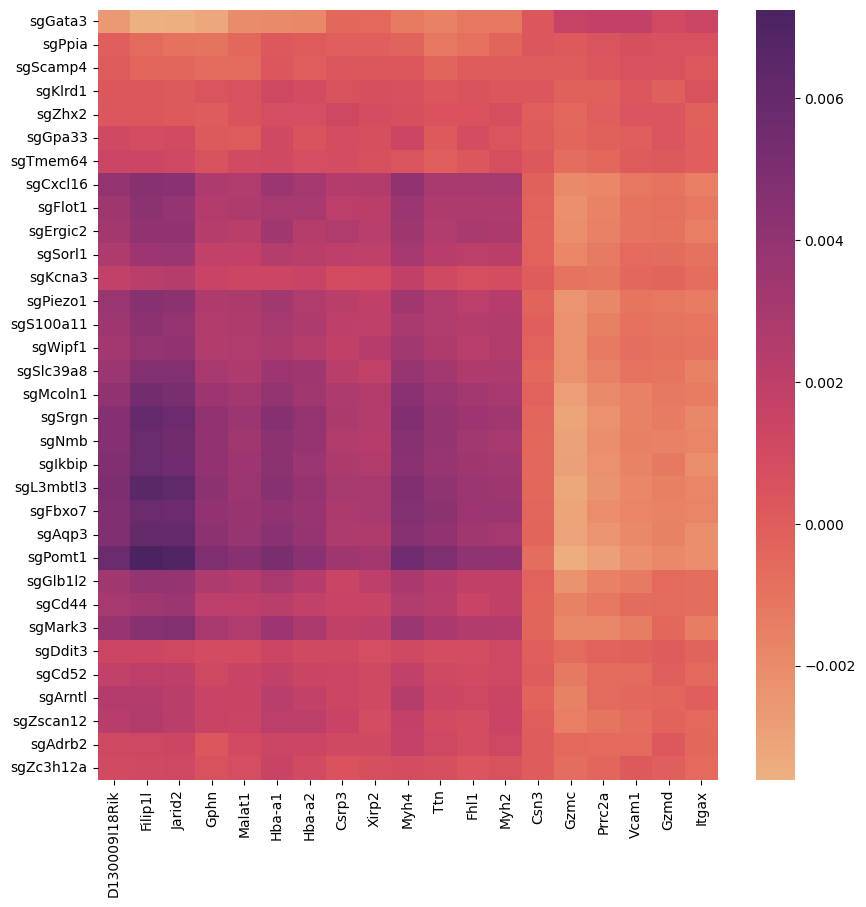

In [62]:
corr_df = pd.DataFrame(corr_matrix.T, columns=interest_genes, index=genes)

interests = []
for ig, g in enumerate(cgdata.var_names[:-1]):
    t = corr_df.iloc[ig, :].sort_values(ascending=False)
    interests += [gene for gene in t.index[:5]]
    t = corr_df.iloc[ig, :].sort_values(ascending=True)
    interests += [gene for gene in t.index[-5:]]

interests = np.unique(interests)
corr_df = corr_df.loc[:, interests]

distance_matrix_gRNA = 1 - corr_df.T.corr()
Z_gRNA = linkage(distance_matrix_gRNA, method='ward')
gRNA_order = leaves_list(Z_gRNA)
distance_matrix_gRNA = 1 - corr_df.corr()
Z_gRNA = linkage(distance_matrix_gRNA, method='ward')
RNA_order = leaves_list(Z_gRNA)
corr_df = corr_df.iloc[gRNA_order, RNA_order]

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_df, cmap="flare", yticklabels=corr_df.index, xticklabels=corr_df.columns, ax=ax)

In [55]:
Tex = ['Havcr2', 'Lag3', 'Pdcd1', 'Entpd1', 'Tigit', 'Ctla4', 'Layn']
Macrophages = ["Ptprc", "Cd14", "Itgam", "Itgax", "Trem2", "Fcgr3a", "Fcgr3b", "Ccr2", "Cd163", "Cd68", "Arg1", "Adgre1", "Cd33", "Cd68", "C1qa", "Cd163",  "C1qb", "C1qc",  "Marco", "Cd81"]
DC = ["Ptprc", "Itgam", "Itgax", "Cd14", "Cd33", "Cd68", "Cd1c", "Cd209", "Ccl22", "Cd86", "Clec9a", "Clec10a", "Xcr1", "Lamp3"]
Endothelial = ["Vwf", "Pecam1", "Cldn5","Cdh5", "Mgp"]
Fibroblasts = ["Col1a1", "Col1a2", "Col3a1","Mmp2", "Myl9", "Dcn","Fap"]
NK = ["Ptprc", "Klrd1", "Mrpl47", "Ncr1", "NkG7", "Gnly", "Klrk1", "Klrc1", "Gzmb", "Klrf1"]
T = ["Ptprc", "Cd3d", "Cd3g", "Cd3e", "Cd8a", "Cd4", "Trbc1","Trbc2","Trac","Gnly", "Klrg1", "Gzmb", "Prf1", "Gzmk", "Ccr7", "Il7r", "Sell", "Lef1", "Tcf7", "Lag3", "Layn", "Havcr2", "Ctla4", "Ggt1", "Tigit", "Cd160", "Tox", "Prdm1", "Socs1", "Eomes", "Tbx21", "Batf", "Foxo1", "Cd4", "Foxp3", "Gata3", "Tbx21", "Cxcr3", "Cd8b"]
B = ["Ptprc", "Cd19", "Tnfrsf17", "Cd79a", "Cd79b", "Slamf7", "Igkc", "Ms4a1"]
Plasma = ["Cd79a", "Mzb1", "Jchain", "Igha1", "Ighg1", "Mki67"]
Neutrophils = ["Ptprc", "S100a9", "Mpo", "Cxcr2", "Csf3r", "Aqp9"]
Malignant = ["Mki67", "Epcam", "Top2a", "Ascl2", "Cbx3", "Hsp90ab1", "Zfas1", "Pabpc1", "Gtf3a", "Nap1l1", "Tgfbi", "Ifitm3", "Hspd1", "Nono", "Hsph1", "Nkd1", "Ly6e", "C6orf48", "Ssb", "Rsl1d1", "Dpep1", "Dkc1", "Bmp4", "Gng4", "Cpne1", "Zdhhc9", "Dars", "Scd", "Myc", "Phlda1", "Dach1", "Cldn1", "Krt23"]
MAST = ["Tpsab1", "Kit"]
Epithelial = ["Cdh1", "Epcam", "Cdkn2a", "Krt5", "Krt17", "Muc5b"]
Hepatocytes = ["Alb","Apoa1","Afp","Tf","Apom","Asgr1","Pck1","Ass1", "Hamp", "Pck1", "Ttrdefb1"]
SmoothMuscle = ["Acta2", "My19", "Myh11", "Mylk","Tagln","Mcam","Actg2","Mgp","Des","Tmp1"]

hallmark_file = open("./GO/mh.all.v2023.2.Mm.symbols.gmt", 'r')
data = []
for line in hallmark_file:
    parts = line.strip().split('\t')
    hallmark = parts[0]
    genes = parts[2:]

    for gene in genes:
        data.append([hallmark, gene])

hallmark_df = pd.DataFrame(data, columns=['Hallmark', 'Gene'])
hallmark_df['Hallmark'] = [mark.lstrip('HALLMARK')[1:].lower() for mark in hallmark_df['Hallmark']]
hallmarks = np.unique(hallmark_df['Hallmark'])

marks = {}
for interest in hallmarks:
    pathway = hallmark_df.loc[hallmark_df['Hallmark'] == f"{interest}", 'Gene']
    d = [gene for gene in deg if np.sum(np.isin(pathway, gene))]
    marks[interest] = d
    # if len(d) > 0: print(interest, d)
marks["t_exhaustion"] = [gene for gene in deg if np.sum(np.isin(Tex, gene))]
marks["macrophages"] = [gene for gene in deg if np.sum(np.isin(Macrophages, gene))]
marks["fibroblasts"] = [gene for gene in deg if np.sum(np.isin(Fibroblasts, gene))]
marks["dentritic"] = [gene for gene in deg if np.sum(np.isin(DC, gene))]
marks["endothelial"] = [gene for gene in deg if np.sum(np.isin(Endothelial, gene))]
marks["natural_killing"] = [gene for gene in deg if np.sum(np.isin(NK, gene))]
marks["t"] = [gene for gene in deg if np.sum(np.isin(T, gene))]
marks["b"] = [gene for gene in deg if np.sum(np.isin(B, gene))]
marks["maglinant"] = [gene for gene in deg if np.sum(np.isin(Malignant, gene))]
marks["plasma"] = [gene for gene in deg if np.sum(np.isin(Plasma, gene))]
marks["neutrophils"] = [gene for gene in deg if np.sum(np.isin(Neutrophils, gene))]
marks["mast"] = [gene for gene in deg if np.sum(np.isin(MAST, gene))]
marks["epithelial"] = [gene for gene in deg if np.sum(np.isin(Epithelial, gene))]
marks["hepatocytes"] = [gene for gene in deg if np.sum(np.isin(Hepatocytes, gene))]
marks["smooth_muscle"] = [gene for gene in deg if np.sum(np.isin(SmoothMuscle, gene))]

In [65]:
genes = cgdata.var_names[:-1]

interest_genes = set()
for key in marks.keys():
    for gene in marks[key]: interest_genes.add(gene)
interest_genes = [gene for gene in interest_genes]

corr_matrix = np.zeros((len(interest_genes), len(genes)))

hvg_matrix = hdata[:, interest_genes].X.toarray()
for i_gene, gene in tqdm(enumerate(genes)):
    guide_vec = guide_matrix[i_gene].reshape(-1, 1)
    
    regr = ElasticNet(random_state=0, alpha=0.1, l1_ratio=0.01)

    regr.fit(guide_vec, hvg_matrix)
    corr_matrix[:,i_gene] = regr.coef_.flatten()

33it [00:01, 18.47it/s]


/tmp/ipykernel_16693/389163979.py:14: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_gRNA = linkage(distance_matrix_gRNA, method='ward')
/tmp/ipykernel_16693/389163979.py:17: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_gRNA = linkage(distance_matrix_gRNA, method='ward')


<Axes: >

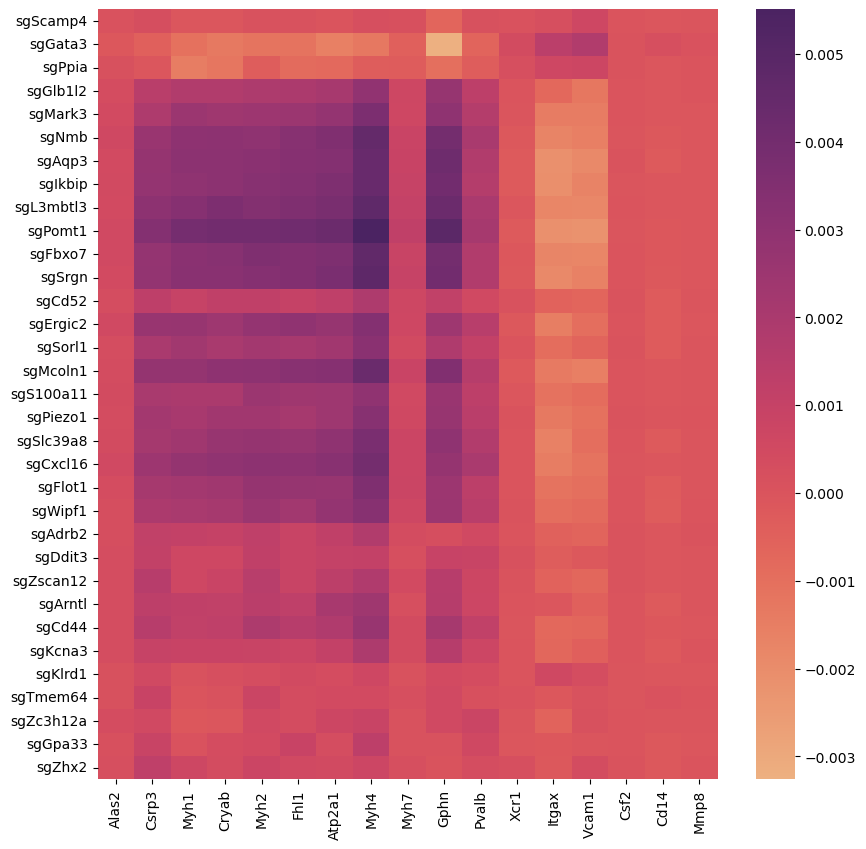

In [66]:
corr_df = pd.DataFrame(corr_matrix.T, columns=interest_genes, index=genes)

interests = []
for ig, g in enumerate(cgdata.var_names[:-1]):
    t = corr_df.iloc[ig, :].sort_values(ascending=False)
    interests += [gene for gene in t.index[:5]]
    t = corr_df.iloc[ig, :].sort_values(ascending=True)
    interests += [gene for gene in t.index[-5:]]

interests = np.unique(interests)
corr_df = corr_df.loc[:, interests]

distance_matrix_gRNA = 1 - corr_df.T.corr()
Z_gRNA = linkage(distance_matrix_gRNA, method='ward')
gRNA_order = leaves_list(Z_gRNA)
distance_matrix_gRNA = 1 - corr_df.corr()
Z_gRNA = linkage(distance_matrix_gRNA, method='ward')
RNA_order = leaves_list(Z_gRNA)
corr_df = corr_df.iloc[gRNA_order, RNA_order]

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_df, cmap="flare", yticklabels=corr_df.index, xticklabels=corr_df.columns, ax=ax)

In [134]:
# Elastic net with 2 variables
genes = cgdata.var_names[:-1]

interest_genes = set()
for key in marks.keys():
    for gene in marks[key]: interest_genes.add(gene)
interest_genes = [gene for gene in interest_genes]

corr_matrix = np.zeros((len(interest_genes), len(genes), len(genes)))

hvg_matrix = hdata[:, interest_genes].X.toarray()
for i_gene, gene in tqdm(enumerate(genes)):
    for j_gene, gene_ in enumerate(genes):
        if gene == gene_: continue
        guide_vec = guide_matrix[(i_gene, j_gene),:].T
        
        regr = ElasticNet(random_state=0, alpha=0.1, l1_ratio=0.01)

        regr.fit(guide_vec, hvg_matrix)
        #print(regr.coef_.shape, regr.coef_)
        corr_matrix[:, i_gene, j_gene] = regr.coef_[:,0]
        corr_matrix[:, j_gene, i_gene] = regr.coef_[:,1]

33it [03:26,  6.26s/it]


In [136]:
#dim2_corr_matrix = corr_matrix
# dim2_corr_matrix:
    # x: interest_gene
    # y: A guide
    # z: B guide

In [150]:
# flatten dim2_corr to a single gene:
target = "sgPiezo1"

corr_matrix = dim2_corr_matrix
genes = cgdata.var_names[:-1]
mask = [(gene == target) for gene in genes]
corr_matrix = corr_matrix[:, mask, :].reshape(corr_matrix.shape[0], corr_matrix.shape[2])
rest_genes = genes[[(not gene) for gene in mask]]
corr_matrix = corr_matrix[:, [(not gene) for gene in mask]]
corr_matrix.shape

(45, 32)

/tmp/ipykernel_16693/1675667140.py:14: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_gRNA = linkage(distance_matrix_gRNA, method='ward')
/tmp/ipykernel_16693/1675667140.py:17: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_gRNA = linkage(distance_matrix_gRNA, method='ward')


<Axes: >

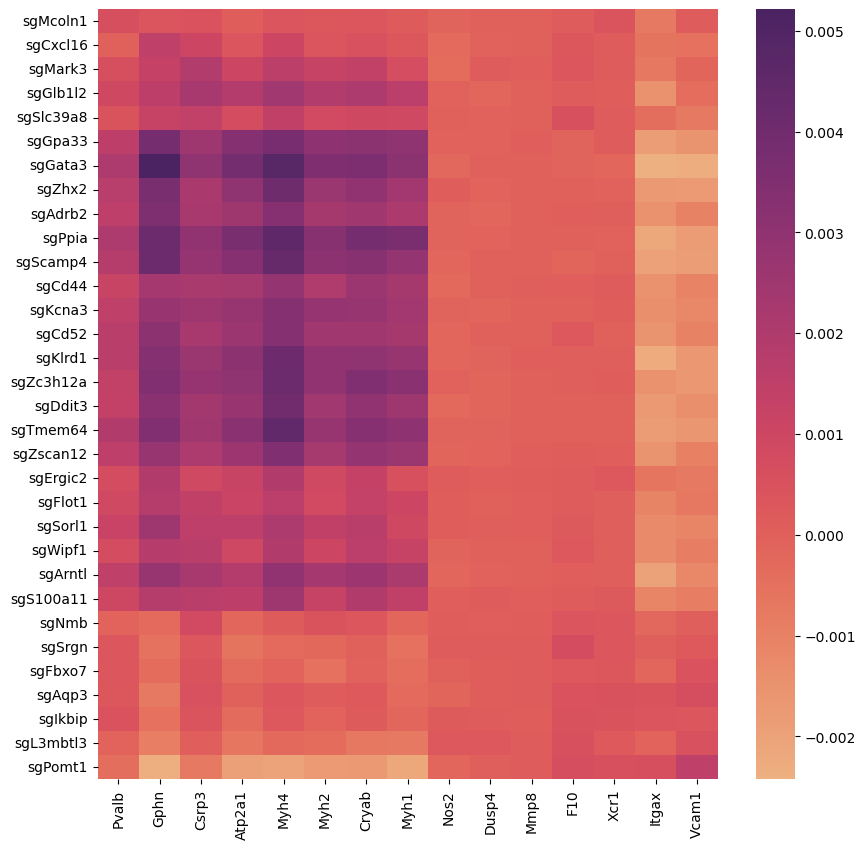

In [151]:
corr_df = pd.DataFrame(corr_matrix.T, columns=interest_genes, index=rest_genes)

interests = []
for ig, g in enumerate(rest_genes):
    t = corr_df.iloc[ig, :].sort_values(ascending=False)
    interests += [gene for gene in t.index[:5]]
    t = corr_df.iloc[ig, :].sort_values(ascending=True)
    interests += [gene for gene in t.index[-5:]]

interests = np.unique(interests)
corr_df = corr_df.loc[:, interests]

distance_matrix_gRNA = 1 - corr_df.T.corr()
Z_gRNA = linkage(distance_matrix_gRNA, method='ward')
gRNA_order = leaves_list(Z_gRNA)
distance_matrix_gRNA = 1 - corr_df.corr()
Z_gRNA = linkage(distance_matrix_gRNA, method='ward')
RNA_order = leaves_list(Z_gRNA)
corr_df = corr_df.iloc[gRNA_order, RNA_order]

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_df, cmap="flare", yticklabels=corr_df.index, xticklabels=corr_df.columns, ax=ax)

In [153]:
# all to all
hvg_matrix = hdata[:, interest_genes].X.toarray()
guide_vec = guide_matrix.T

regr = ElasticNet(random_state=0, alpha=0.1, l1_ratio=0.01)

regr.fit(guide_vec, hvg_matrix)
regr.coef_.shape

(45, 34)

/tmp/ipykernel_16693/2404595368.py:14: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_gRNA = linkage(distance_matrix_gRNA, method='ward')
/tmp/ipykernel_16693/2404595368.py:17: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_gRNA = linkage(distance_matrix_gRNA, method='ward')


<Axes: >

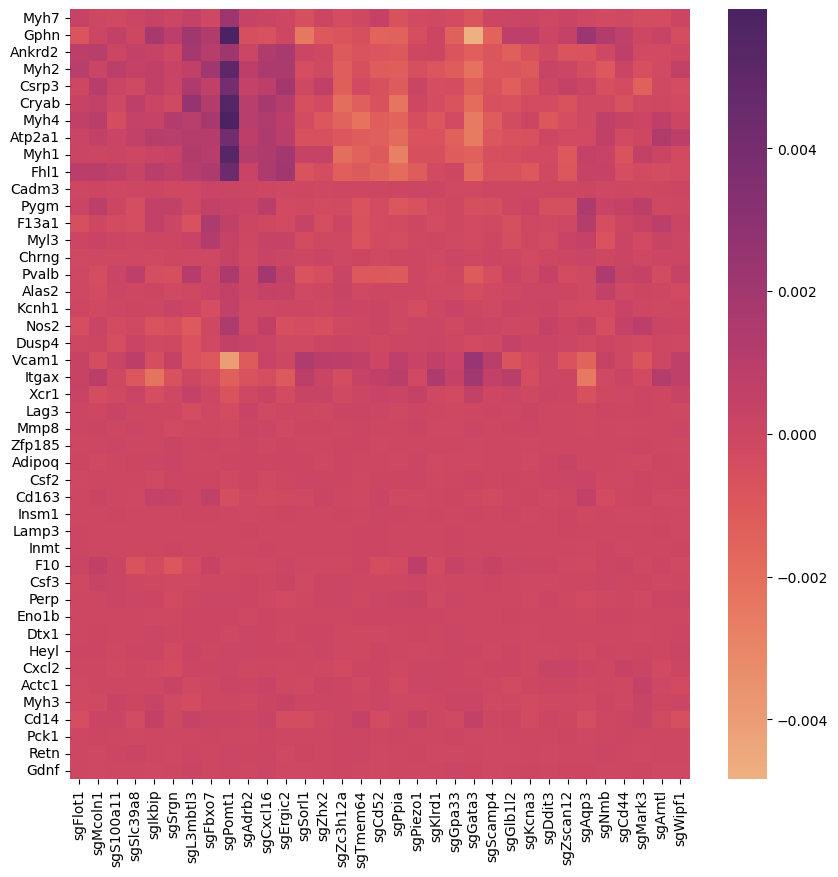

In [161]:
corr_df = pd.DataFrame(regr.coef_, columns=cgdata.var_names, index=interest_genes)

interests = []
for ig, g in enumerate(rest_genes):
    t = corr_df.iloc[ig, :].sort_values(ascending=False)
    interests += [gene for gene in t.index[:5]]
    t = corr_df.iloc[ig, :].sort_values(ascending=True)
    interests += [gene for gene in t.index[-5:]]

interests = np.unique(interests)
corr_df = corr_df.loc[:, interests]

distance_matrix_gRNA = 1 - corr_df.T.corr()
Z_gRNA = linkage(distance_matrix_gRNA, method='ward')
gRNA_order = leaves_list(Z_gRNA)
distance_matrix_gRNA = 1 - corr_df.corr()
Z_gRNA = linkage(distance_matrix_gRNA, method='ward')
RNA_order = leaves_list(Z_gRNA)

corr_df = corr_df.iloc[gRNA_order, RNA_order]
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_df, cmap="flare", yticklabels=corr_df.index, xticklabels=corr_df.columns, ax=ax)